In [1]:
import torch
import torchvision

from score_models.models.unet import UNet
from score_models.sampling import annealed_langevin_dynamics
from score_models.utils.noise import get_sigmas
from score_models.utils.visualisations import show_torch_images

In [2]:
L=10
in_ch = 3
ch = 128
ch_mult = [1, 2, 3, 4]
attn = [2]
num_res_blocks = 2
dropout = 0.15
device = "cuda"

# construct score model
score_model = UNet(
    T=L, 
    in_ch=in_ch, 
    ch=ch, 
    ch_mult=ch_mult, 
    attn=attn, 
    num_res_blocks=num_res_blocks, 
    dropout=dropout,
).to(device)

# load pre-trained model
path = "../scripts/checkpoints/cifar10/200000.pt"
score_model.load_state_dict(
    torch.load(path)["model_state_dict"]
)

# define train step (i.e., criterion)
sigma_min, sigma_max = 0.01, 1.0
sigmas = get_sigmas(L=L, sigma_min=sigma_min, sigma_max=sigma_max)

In [3]:
samples = annealed_langevin_dynamics(
    score_model=score_model, 
    input_size=(8, 3, 32, 32), 
    sigmas=sigmas,
    T=100,
    eps=2e-5,
    r=[0, 1]
).cpu()

samples = torch.clamp(samples, 0, 1)

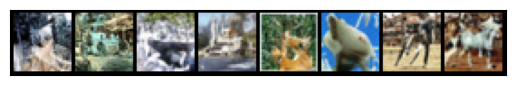

In [4]:
grid = torchvision.utils.make_grid(samples, nrow=8, normalize=True, value_range=(0, 1))
show_torch_images(grid)